In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
seed = 0

In [4]:
DATASETX = "./data/prep/HotelReservationsPreparedCleanX.csv"
DATASETY = "./data/prep/HotelReservationsY.csv"

In [5]:
df_x = pd.read_csv(DATASETX)
df_y = pd.read_csv(DATASETY)

In [6]:
df_x.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,0.0,-0.6,-1.000000,-0.882353,-1.0,1.0,-1.0,-0.990971,0.454545,-0.933333,0.0,-1.0,-1.0,-1.0,-0.044444,-0.6
1,0.0,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.823928,0.272727,-0.133333,-1.0,-1.0,-1.0,-1.0,-0.624074,-1.0
2,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.936795,1.000000,0.733333,0.0,-1.0,-1.0,-1.0,-0.603704,-1.0
3,0.0,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.548533,0.636364,0.000000,-1.0,-1.0,-1.0,-1.0,-0.600000,-1.0
4,-0.5,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.002257,0.272727,-0.266667,-1.0,-1.0,-1.0,-1.0,-0.729630,-1.0


In [7]:
df_y.head()

,booking_status
0,1
1,1
2,1
3,0
4,1


In [8]:
df = pd.concat([df_x, df_y], axis=1)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0.0,-0.6,-1.000000,-0.882353,-1.0,1.0,-1.0,-0.990971,0.454545,-0.933333,0.0,-1.0,-1.0,-1.0,-0.044444,-0.6,1
1,0.0,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.823928,0.272727,-0.133333,-1.0,-1.0,-1.0,-1.0,-0.624074,-1.0,1
2,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.936795,1.000000,0.733333,0.0,-1.0,-1.0,-1.0,-0.603704,-1.0,1
3,0.0,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.548533,0.636364,0.000000,-1.0,-1.0,-1.0,-1.0,-0.600000,-1.0,0
4,-0.5,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.002257,0.272727,-0.266667,-1.0,-1.0,-1.0,-1.0,-0.729630,-1.0,1


In [9]:
df = shuffle(df, random_state=seed)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
17405,0.0,-1.0,-0.714286,-0.882353,-1.0,1.0,0.0,-0.959368,0.272727,-0.200000,0.0,-1.0,-1.0,-1.0,-0.388889,0.2,1
25403,0.0,-1.0,-1.000000,-0.882353,-1.0,-1.0,0.0,-0.936795,0.636364,0.400000,0.0,-1.0,-1.0,-1.0,-0.407407,-1.0,0
13544,0.5,-1.0,-1.000000,-0.647059,-1.0,-1.0,1.0,-0.638826,0.272727,-0.866667,0.0,-1.0,-1.0,-1.0,-0.499000,-0.6,1
31848,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,1.0,-0.864560,0.636364,0.000000,0.0,-1.0,-1.0,-1.0,-0.560815,-0.6,1
9691,-0.5,-1.0,-0.428571,-0.411765,-1.0,-1.0,1.0,-0.977427,0.636364,-0.333333,1.0,-1.0,-1.0,-1.0,-0.592593,-1.0,1


In [10]:
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1

In [11]:
train_set, temp_set = train_test_split(df, train_size=TRAIN_SIZE, random_state=seed)

validation_set, test_set = train_test_split(temp_set, train_size=VALIDATION_SIZE / (VALIDATION_SIZE + TEST_SIZE), random_state=seed)

In [12]:
X_train = train_set.drop('booking_status', axis=1)
y_train = train_set['booking_status']

X_val = validation_set.drop('booking_status', axis=1)
y_val = validation_set['booking_status']

X_test = test_set.drop('booking_status', axis=1)
y_test = test_set['booking_status']

In [13]:
train_set.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
6673,0.5,-1.0,-0.714286,-0.647059,-1.0,-1.0,1.0,-0.566591,0.454545,-1.000000,0.0,-1.0,-1.0,-1.0,-0.385000,0.6,1
29596,0.0,-1.0,-1.000000,-0.882353,1.0,-1.0,0.0,-0.995485,1.000000,-0.400000,0.0,-1.0,-1.0,-1.0,-0.685185,-1.0,1
19931,0.0,-1.0,-1.000000,-0.529412,-1.0,-1.0,0.0,-0.241535,0.636364,-0.800000,-1.0,-1.0,-1.0,-1.0,-0.641481,-1.0,0
28615,-0.5,-1.0,-0.714286,-1.000000,-1.0,-1.0,0.0,-0.467269,0.454545,0.133333,-1.0,-1.0,-1.0,-1.0,-0.537037,-1.0,0
17993,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.665914,-0.454545,0.066667,-1.0,-1.0,-1.0,-1.0,-0.722222,-1.0,1


In [14]:
validation_set.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
31751,0.5,-1.0,-1.000000,-0.882353,-1.0,-1.0,1.0,-0.936795,0.454545,-0.066667,0.0,-1.0,-1.0,-1.0,-0.240741,-0.2,1
12851,0.0,-1.0,-1.000000,-0.647059,0.0,-1.0,0.0,-0.083521,1.000000,-0.533333,0.0,-1.0,-1.0,-1.0,-0.583333,-1.0,1
12496,0.0,-1.0,-0.714286,-0.647059,1.0,-1.0,0.0,-0.273138,0.090909,-0.600000,0.0,-1.0,-1.0,-1.0,-0.637963,-0.6,0
25515,0.0,-1.0,-0.714286,-0.529412,-1.0,-1.0,1.0,-0.851016,0.636364,0.800000,-1.0,-1.0,-1.0,-1.0,-0.713333,-1.0,1
15510,0.0,-1.0,-1.000000,-0.764706,-1.0,-1.0,0.0,-0.733634,-1.000000,0.800000,-1.0,-1.0,-1.0,-1.0,-0.677778,-0.6,1


In [15]:
test_set.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
8732,0.0,-1.0,-0.428571,-1.000000,1.0,-1.0,0.0,-0.846501,0.454545,0.600000,0.0,-1.0,-1.0,-1.0,-0.633333,-0.6,1
12913,0.0,-1.0,-0.428571,-0.647059,-1.0,-1.0,0.0,0.367946,0.272727,0.200000,0.0,-1.0,-1.0,-1.0,-0.711111,-1.0,0
5482,-0.5,-1.0,-1.000000,-0.764706,-1.0,-1.0,0.0,-0.259594,0.636364,-0.933333,-1.0,-1.0,-1.0,-1.0,-0.629630,-1.0,1
9848,0.5,-1.0,-0.714286,-0.647059,-1.0,-1.0,1.0,-0.941309,-0.272727,-0.733333,0.0,-1.0,-1.0,-1.0,-0.372222,-0.2,1
30631,0.0,-1.0,-0.714286,-0.882353,0.0,-1.0,0.0,0.115124,-0.090909,-0.666667,-1.0,-1.0,-1.0,-1.0,-0.574074,-0.6,0


In [16]:
print("Train: ", X_train.shape)
print("Test: ", X_test.shape)
print("Validation: ", X_val.shape)

Train:  (29016, 16)
Test:  (3627, 16)
Validation:  (3627, 16)


In [17]:
INPUTS = X_train.shape[1]
OUTPUTS = 1
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (X_val.shape[0]/1))

In [18]:
n_epochs = 100
lr = 0.001
batch_size = 250
tasa_dropout = 0.2
n_neurons_per_hlayer = [100, 50, 25, 10]

In [19]:
model = keras.Sequential(name="DeepFeedforward")

In [20]:
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, activation="relu"))
  model.add(tf.keras.layers.Dropout(tasa_dropout))

model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "DeepFeedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1700      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 10)            

In [21]:
weights, biases = model.layers[0].get_weights()
weights.shape

(16, 100)

In [22]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["binary_accuracy"]
)


In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(29016, 16)
(29016,)
(3627, 16)
(3627,)


In [24]:
start = time.perf_counter()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X_val, y_val))
print (time.perf_counter() - start)

Epoch 1/100


c:\dev\DL\venv\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


117/117 [==============================] - 2s 5ms/step - loss: 0.6048 - binary_accuracy: 0.6628 - val_loss: 0.4865 - val_binary_accuracy: 0.7703
Epoch 2/100
 16/117 [===>..........................] - ETA: 0s - loss: 0.5153 - binary_accuracy: 0.7523

c:\dev\DL\venv\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


117/117 [==============================] - 0s 4ms/step - loss: 0.4830 - binary_accuracy: 0.7755 - val_loss: 0.4468 - val_binary_accuracy: 0.7794
Epoch 3/100
117/117 [==============================] - 0s 4ms/step - loss: 0.4554 - binary_accuracy: 0.7910 - val_loss: 0.4311 - val_binary_accuracy: 0.7891
Epoch 4/100
117/117 [==============================] - 0s 4ms/step - loss: 0.4422 - binary_accuracy: 0.8004 - val_loss: 0.4228 - val_binary_accuracy: 0.7935
Epoch 5/100
117/117 [==============================] - 0s 4ms/step - loss: 0.4337 - binary_accuracy: 0.8036 - val_loss: 0.4109 - val_binary_accuracy: 0.8026
Epoch 6/100
117/117 [==============================] - 0s 4ms/step - loss: 0.4216 - binary_accuracy: 0.8099 - val_loss: 0.4070 - val_binary_accuracy: 0.8053
Epoch 7/100
117/117 [==============================] - 0s 4ms/step - loss: 0.4142 - binary_accuracy: 0.8132 - val_loss: 0.4021 - val_binary_accuracy: 0.8106
Epoch 8/100
117/117 [==============================] - 0s 4ms/step - l

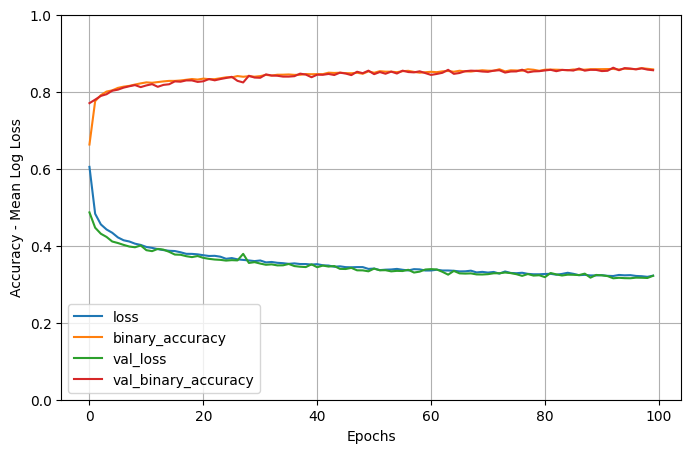

In [25]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig(f"./images/loss{n_neurons_per_hlayer}.png")
plt.show()

In [26]:
results[-1:]

,loss,binary_accuracy,val_loss,val_binary_accuracy
99,0.322284,0.858009,0.321972,0.855804


In [27]:
print(f"Accuracy for the training set: {results.binary_accuracy.values[-1:][0]}")
print(
    f"Accuracy for the development test set: {results.val_binary_accuracy.values[-1:][0]}"
)

Accuracy for the training set: 0.858009397983551
Accuracy for the development test set: 0.8558036684989929


In [28]:
v = open("./history/DeepFeedforward.txt", "a")
v.write(f"Epoque: {n_epochs}\n")
v.write(f"Learning Rate: {lr}\n")
v.write(f"Batch Size: {batch_size}\n")
v.write(f"Dropout: {tasa_dropout}\n")
v.write(f"Neurons per layer: {n_neurons_per_hlayer}\n")
v.write(f"Activation: relu\n")
v.write(f"Optimizer: Adam\n")
v.write(
    "--------------------------------------------------------------------------------------------\n"
)
v.write(f"Accuracy for the training set: {results.binary_accuracy.values[-1:][0]}\n")
v.write(
    f"Accuracy for the development test set: {results.val_binary_accuracy.values[-1:][0]}\n"
)
v.write(f"Time: {time.perf_counter() - start}\n")
v.write(
    "--------------------------------------------------------------------------------------------\n"
)
v.close()